In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval

from seisLM.model import supervised_models

# from seisLM.utils.project_path import gitdir
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from seisLM.utils import project_path

In [2]:
# for data_name in data_aliases.keys():

pick_eval.save_pick_predictions(
    checkpoint_path_or_data_name="/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/ethz_seisLM/42__2024-06-07-10h-43m-45s/checkpoints/epoch=28-step=5104.ckpt",
    model_name='MultiDimWav2Vec2ForFrameClassification',
    targets=project_path.gitdir() + '/data/targets/ethz/',
    sets='dev,test',
    batchsize=64
)

/scicore/home/dokman0000/liu0003/anaconda3/envs/seisbench/lib/python3.9/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2527: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(
2024-06-07 12:10:34,325 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
Preloading waveforms: 100%|██████████| 3632/3632 [00:22<00:00, 160.14it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 10485/10485 [01:07<00:00, 155.12it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

# Taks 1 - event detection

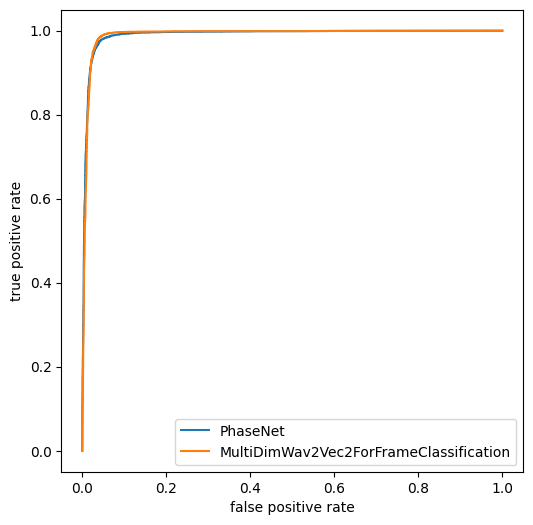

In [17]:
task = 1 # '23'
eval_set = 'test' #'test'
data_name = 'ethz'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

for model_name in ['PhaseNet', 'MultiDimWav2Vec2ForFrameClassification']:

  pred_path = (
    Path(project_path.EVAL_SAVE_DIR)
    / f"{model_name}_{data_name}"
    / f"{eval_set}_task{task}.csv"
  )

  pred = pd.read_csv(pred_path)

  pred["trace_type_bin"] = pred["trace_type"] == "earthquake"

  fpr, tpr, _ = roc_curve(pred["trace_type_bin"], pred["score_detection"])

  ax.plot(fpr, tpr, label=model_name)
  ax.set_aspect("equal")

  ax.set_xlabel("false positive rate")
  ax.set_ylabel("true positive rate")
  # ax.set_title(f"{model_name}; train: {data_name}; eval: {eval_set}-{task}")
plt.legend()

PhaseNet | Optimal F1: 0.9673177883933217
PhaseNet | Optimal F1 threshold: 0.35434717
MultiDimWav2Vec2ForFrameClassification | Optimal F1: 0.9719643782688593
MultiDimWav2Vec2ForFrameClassification | Optimal F1 threshold: 0.43047863


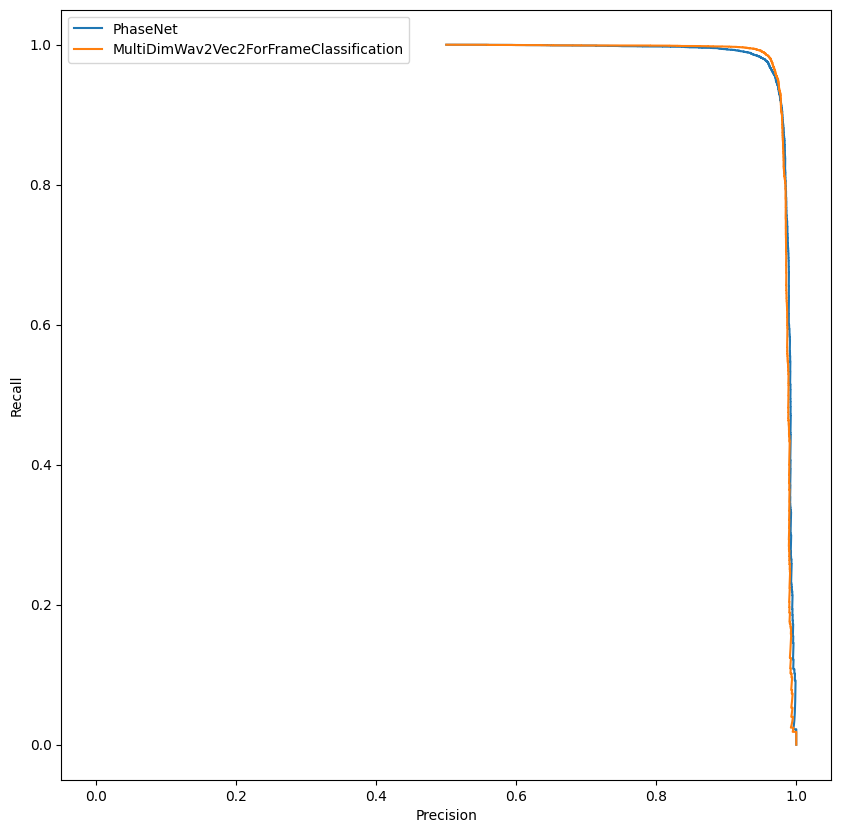

In [10]:
task = 1 # '23'
eval_set = 'test' #'test'
model_name = 'PhaseNet'
data_name = 'ethz'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for model_name in ['PhaseNet', 'MultiDimWav2Vec2ForFrameClassification']:

  pred_path = (
    Path(project_path.EVAL_SAVE_DIR)
    / f"{model_name}_{data_name}"
    / f"{eval_set}_task{task}.csv"
  )

  pred = pd.read_csv(pred_path)
  pred["trace_type_bin"] = pred["trace_type"] == "earthquake"

  prec, recall, thr = precision_recall_curve(pred["trace_type_bin"], pred["score_detection"])

  f1 = 2 * prec * recall / (prec + recall)
  f1_threshold = thr[np.nanargmax(f1)]
  best_f1 = np.max(f1)

  # fig = plt.figure(figsize=(10, 10))
  # ax = fig.add_subplot(111)
  ax.plot(prec, recall, label=model_name)
  ax.set_aspect("equal")

  ax.set_xlabel("Precision")
  ax.set_ylabel("Recall")
  ax.set_xlim(ax.get_ylim())

  print(f"{model_name} | Optimal F1:", best_f1)
  print(f"{model_name} | Optimal F1 threshold:", f1_threshold)

plt.legend()

# Task 2 - Phase identification

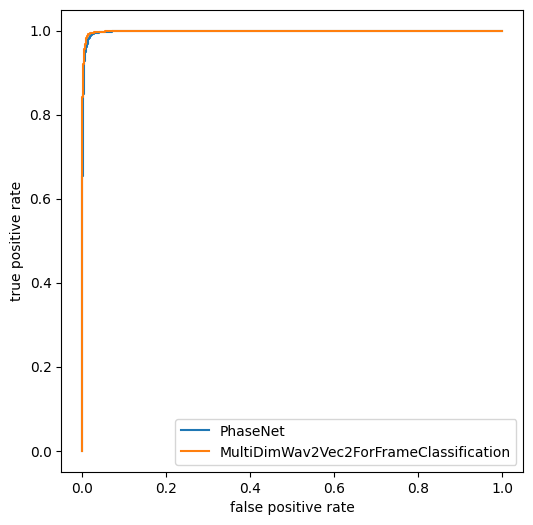

In [22]:
task = '23'
eval_set = 'test' #'test'
data_name = 'ethz'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

for model_name in ['PhaseNet', 'MultiDimWav2Vec2ForFrameClassification']:

  pred_path = (
    Path(project_path.EVAL_SAVE_DIR)
    / f"{model_name}_{data_name}"
    / f"{eval_set}_task{task}.csv"
  )
  pred = pd.read_csv(pred_path)

  pred["phase_label_bin"] = pred["phase_label"] == "P"

  fpr, tpr, _ = roc_curve(pred["phase_label_bin"], pred["score_p_or_s"])

  # fig = plt.figure(figsize=(10, 10))
  # ax = fig.add_subplot(111)
  ax.plot(fpr, tpr, label=model_name)
  ax.set_aspect("equal")

  ax.set_xlabel("false positive rate")
  ax.set_ylabel("true positive rate")
  # ax.set_yscale('log')
  # ax.set_xscale('log')
plt.legend()


PhaseNet | Optimal F1: 0.9883827575664933
PhaseNet | Optimal F1 threshold: 1.0150024
MultiDimWav2Vec2ForFrameClassification | Optimal F1: 0.9912509593246355
MultiDimWav2Vec2ForFrameClassification | Optimal F1 threshold: 1.0160483


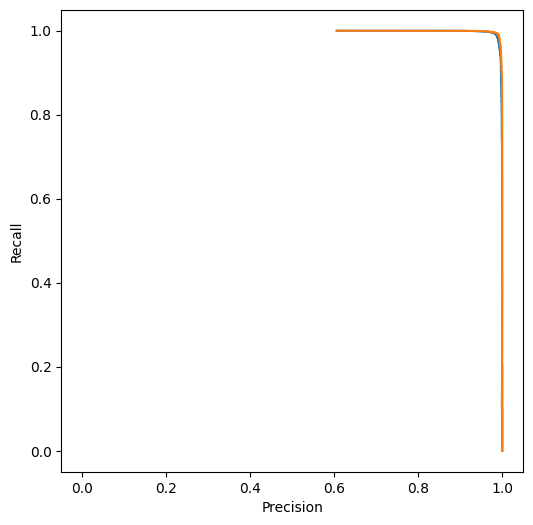

In [28]:
task = '23'
eval_set = 'test' #'test'
data_name = 'ethz'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

for model_name in ['PhaseNet', 'MultiDimWav2Vec2ForFrameClassification']:

  pred_path = (
    Path(project_path.EVAL_SAVE_DIR)
    / f"{model_name}_{data_name}"
    / f"{eval_set}_task{task}.csv"
  )
  pred = pd.read_csv(pred_path)

  pred["phase_label_bin"] = pred["phase_label"] == "P"
  
  prec, recall, thr = precision_recall_curve(pred["phase_label_bin"], pred["score_p_or_s"])

  f1 = 2 * prec * recall / (prec + recall)
  f1_threshold = thr[np.nanargmax(f1)]
  best_f1 = np.max(f1)

  # fig = plt.figure(figsize=(10, 10))
  # ax = fig.add_subplot(111)
  ax.plot(prec, recall, label=model_name)
  ax.set_aspect("equal")

  ax.set_xlabel("Precision")
  ax.set_ylabel("Recall")
  ax.set_xlim(ax.get_ylim())

  print(f"{model_name} | Optimal F1:", best_f1)
  print(f"{model_name} | Optimal F1 threshold:", f1_threshold)


In [29]:
model

NameError: name 'model' is not defined

dataset: ethz | model: PhaseNet | phase P | MAE 0.08313075977882442
dataset: ethz | model: MultiDimWav2Vec2ForFrameClassification | phase P | MAE 0.07467755478160952
dataset: ethz | model: PhaseNet | phase S | MAE 0.13480471168482605
dataset: ethz | model: MultiDimWav2Vec2ForFrameClassification | phase S | MAE 0.13062264546930577


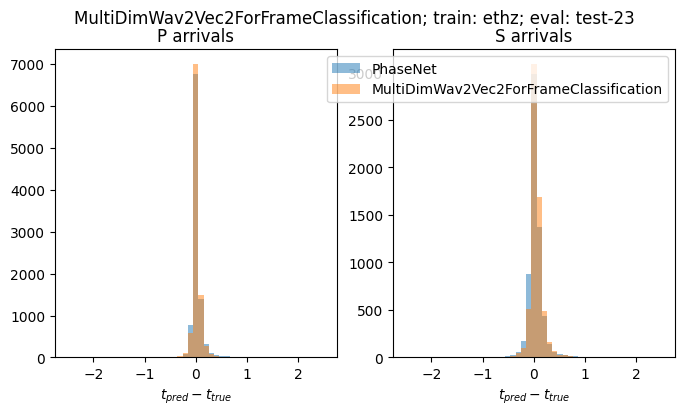

In [24]:
import numpy as np

task = 23
eval_set = 'test' #'test'


fig = plt.figure(figsize=(8, 4))
axs = fig.subplots(1, 2)

for i, phase in enumerate(["P", "S"]):

  for model_name in ['PhaseNet', 'MultiDimWav2Vec2ForFrameClassification']:
    pred_path = (
      Path(project_path.EVAL_SAVE_DIR)
      / f"{model_name}_{data_name}"
      / f"{eval_set}_task{task}.csv"
    )
    pred = pd.read_csv(pred_path)


    ax = axs[i]
    ax.set_title(f"{phase} arrivals")
    pred_phase = pred[pred["phase_label"] == phase]
    pred_col = f"{phase.lower()}_sample_pred"

    diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase["sampling_rate"]

    print(f'dataset: {data_name} | model: {model_name} | phase {phase} | MAE {diff.abs().mean()}')
    bins = np.linspace(-2.5, 2.5, 50)
    ax.hist(diff, bins=bins, label=model_name, alpha=0.5)
    ax.set_xlabel("$t_{pred} - t_{true}$")
  plt.suptitle(f"{model_name}; train: {data_name}; eval: {eval_set}-{task}")

plt.legend()